In [27]:
import numpy as np
import uproot
import matplotlib.colors as Colors
from matplotlib.markers import MarkerStyle
from scipy.optimize import curve_fit
import scipy.special as sp
from mpl_toolkits.axes_grid1 import make_axes_locatable


import matplotlib.pyplot as plt
plt.style.use('sensitivity.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def GetFVCut(tree):
    cut = np.where((tree['passed_xy_thresh'].array() == True) \
               & (tree['passed_z_thresh'].array() == True) \
               & (tree['n_x_ch_abovenoise'].array() > 0) \
               & (tree['n_y_ch_abovenoise'].array() > 0) \
               & (tree['standoff'].array() > 20.0) \
               & (tree['energy'].array() > 700) \
               & (tree['NESTBugFound'].array() == False) \
               & (tree['NearAnodeBugFound'].array() == False) \
              )
    return cut  

In [3]:
def gauss(x,a,b,c,d,e):
    return a*np.exp(-(x-b)**2/(2*c**2)) + a*sp.erf(d)+e

In [4]:
Path = '/gpfs/slac/staas/fs1/g/exo/exo_data8/exo_data/users/nexo_sensitivity2020/merged-v11/'

In [5]:
th232 = uproot.open(Path+'Baseline2019_Th232_TPCVessel.root')['tree']

In [6]:
th232_cut = GetFVCut(th232)

In [7]:
light = th232['m_nOPCal'].array()[th232_cut]/1000.0
charge = th232['m_nQ'].array()[th232_cut]/1000.0
total = charge+light/1.35

In [8]:
light_hist, light_hist_x = np.histogram(light, bins=np.linspace(40,160,500))
charge_hist, charge_hist_x = np.histogram(charge, bins=np.linspace(40,160,500))
total_hist, total_hist_x = np.histogram(total, bins=np.linspace(40,300,500))

Light only energy resolution: 4.48%
Charge only energy resolution: 2.87%
Rotated energy resolution: 0.88%


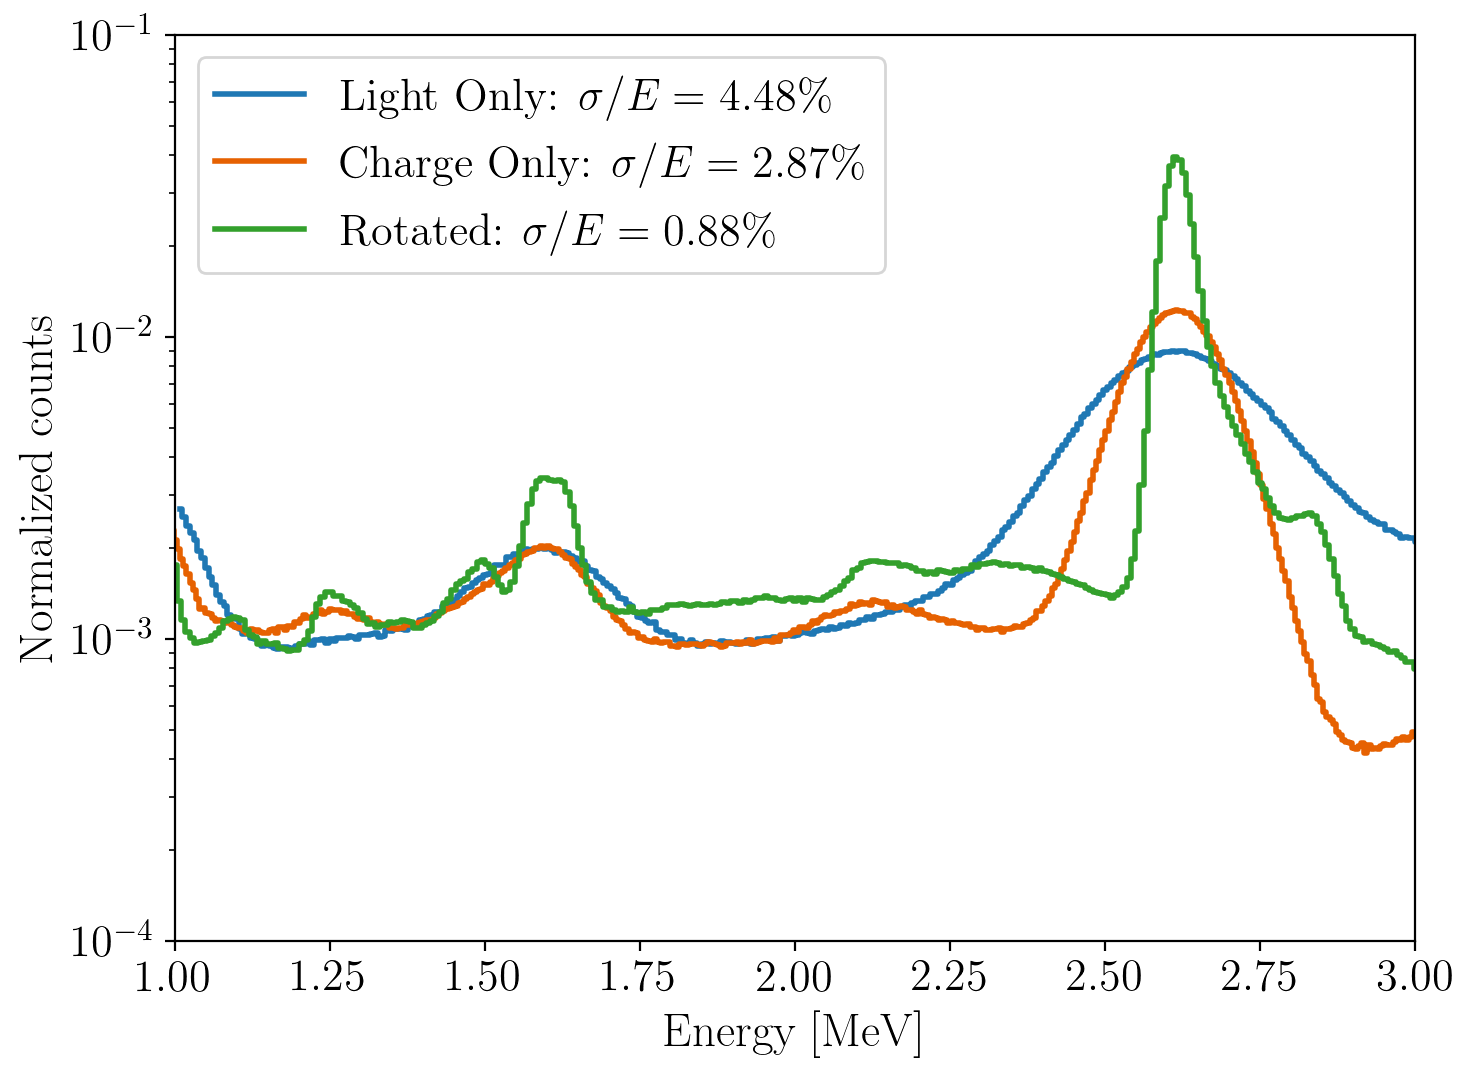

In [9]:
plt.figure()
plt.xlim(1,3)
plt.ylim(1e-4,1e-1)
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Normalized counts')


light_cut = np.where((light_hist_x > 98) & (light_hist_x<110) )
popt, pcov = curve_fit(gauss, light_hist_x[:-1][light_cut], (light_hist/np.max(light_hist))[light_cut], p0=[1, 105, 20,1,0])
xfit = np.linspace(98,110,1000)*2.615/popt[1]

plt.step(light_hist_x[:-1]*2.615/popt[1], light_hist/np.sum(light_hist), where='mid', label='Light Only: $\sigma/E={:.2f}$\%'.format(np.abs(popt[2]/popt[1]*100.0)))
# plt.plot(xfit, gauss(xfit, popt[0], popt[1]*2.615/popt[1], popt[2]*2.615/popt[1], popt[3], popt[4]))
print('Light only energy resolution: {:.2f}%'.format(np.abs(popt[2]/popt[1]*100.0)))


charge_cut = np.where((charge_hist_x > 119) & (charge_hist_x<128) )
popt2, pcov2 = curve_fit(gauss, charge_hist_x[:-1][charge_cut], (charge_hist/np.max(charge_hist))[charge_cut], p0=[1, 120, 20,1,0])
xfit2 = np.linspace(119,128,1000)*2.615/popt2[1]

plt.step(charge_hist_x[:-1]*2.615/popt2[1], charge_hist/np.sum(charge_hist), where='mid', label='Charge Only: $\sigma/E={:.2f}$\%'.format(np.abs(popt2[2]/popt2[1]*100.0)))
# plt.plot(xfit2, gauss(xfit2, popt2[0], popt2[1]*2.615/popt2[1], popt2[2]*2.615/popt2[1], popt2[3], popt2[4]))
print('Charge only energy resolution: {:.2f}%'.format(np.abs(popt2[2]/popt2[1]*100.0)))


total_cut = np.where((total_hist_x > 196) & (total_hist_x<202) )
popt3, pcov3 = curve_fit(gauss, total_hist_x[:-1][total_cut], (total_hist/np.max(total_hist))[total_cut], p0=[1, 200, 10,1,0])
xfit3 = np.linspace(196,202,1000)*2.615/popt3[1]

plt.step(total_hist_x[:-1]*2.615/popt3[1], total_hist/np.sum(total_hist), where='mid', label='Rotated: $\sigma/E={:.2f}$\%'.format(np.abs(popt3[2]/popt3[1]*100.0)))
# plt.plot(xfit3, gauss(xfit3, popt3[0], popt3[1]*2.615/popt3[1], popt3[2]*2.615/popt3[1], popt3[3], popt3[4]))
print('Rotated energy resolution: {:.2f}%'.format(np.abs(popt3[2]/popt3[1]*100.0)))


plt.legend(loc='upper left')
plt.savefig('energyres_vs_channel.png')
plt.savefig('energyres_vs_channel.pdf')
plt.show()

In [10]:
print(popt[1])
print(popt2[1])
xcenter = popt2[1]
ycenter = popt[1]

103.7399191477722
123.46427069029714


In [11]:
hist, xedges, yedges = np.histogram2d(charge, light, bins=[np.linspace(40,160,300), np.linspace(40,160,300)])

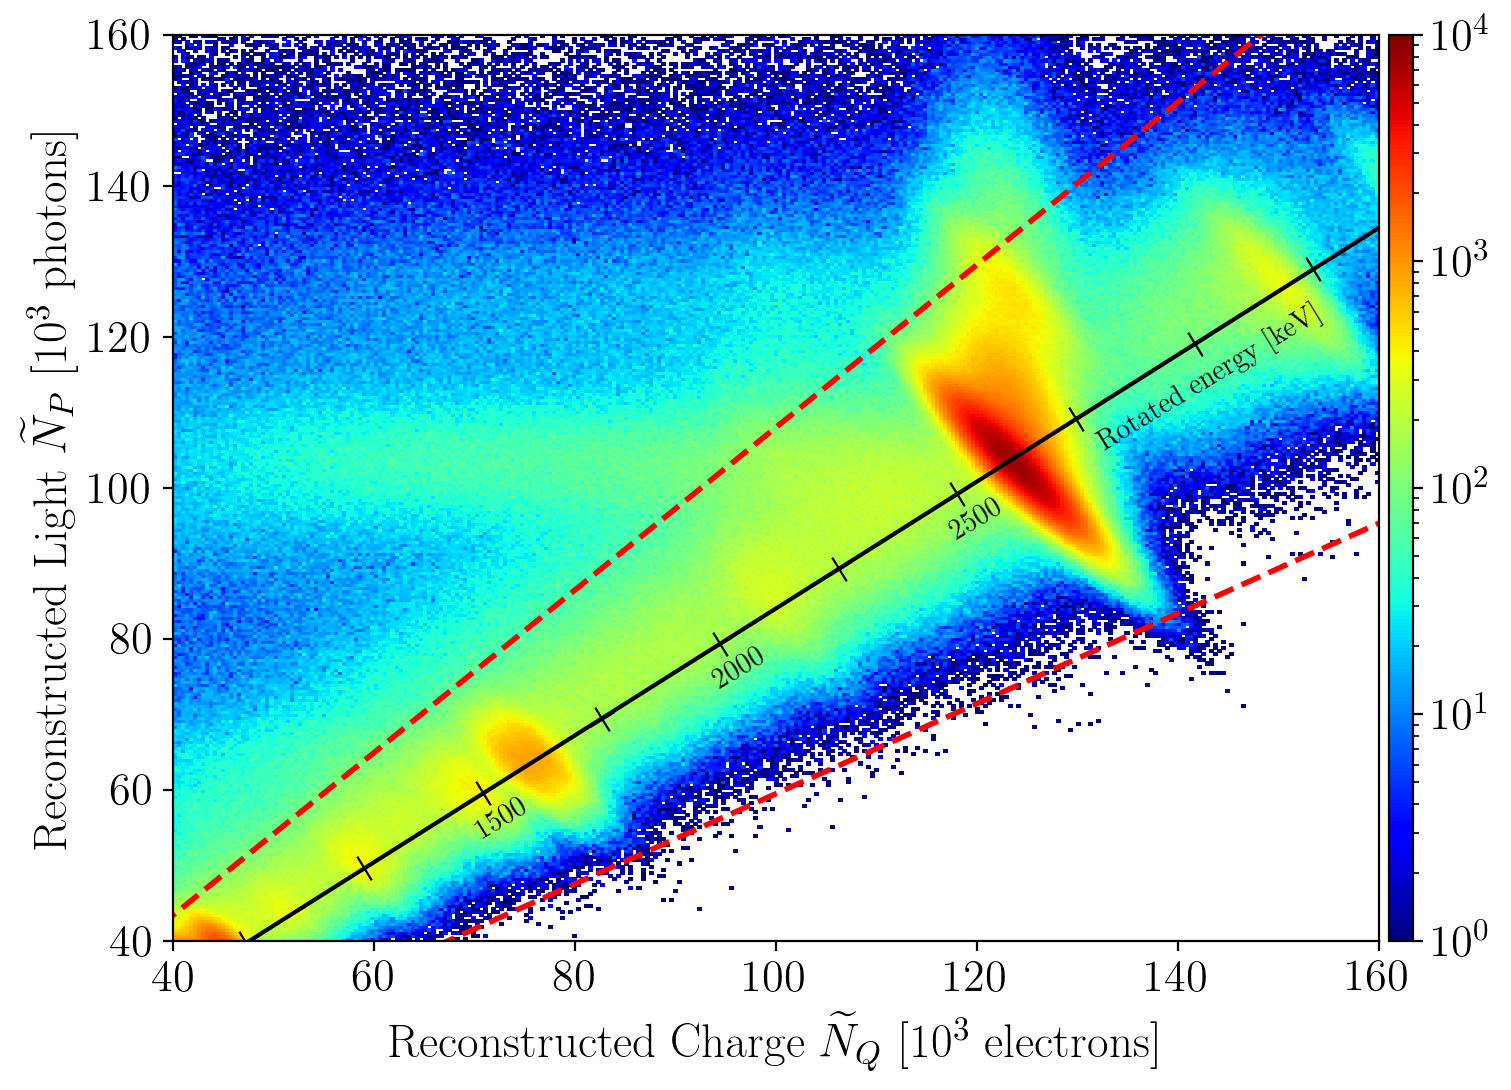

In [35]:
fig, ax = plt.subplots()
plt.xlim(40,160)
plt.ylim(40,160)
plt.xlabel("Reconstructed Charge " + r"$\widetilde{N}_Q$" + " [10$^{3}$ electrons]")
plt.ylabel("Reconstructed Light " + r"$\widetilde{N}_P$" + " [10$^{3}$ photons]")

im = plt.pcolormesh(xedges, yedges, hist.T, norm=Colors.LogNorm(vmin=1,vmax=np.max(hist)), cmap='jet')

# Calculate rotation angle from Tl-208 peak position wrt the origin
rotangle = np.arctan(ycenter/xcenter) * 45.0 

# Add rotated energy axis
plt.plot([0,2*xcenter], [0,2*ycenter],'k',lw=1.5, ls='-')

xs = np.linspace(0,200,100)
ys_diag = xs - np.abs(xcenter-ycenter)
# plt.plot(np.linspace(119,129,100), np.linspace(119,129,100)-np.abs(xcenter-ycenter),'k',lw=1.5, ls='--')

# plt.plot(np.linspace(0,200,100), np.linspace(0,200,100),'k',lw=1.5, ls=':')
# plt.plot(np.linspace(0,200,100), np.linspace(200,0,100),'k',lw=1.5, ls=':')
# plt.plot(np.linspace(119,129,100), (np.linspace(119,129,100)-np.abs(xcenter-ycenter))[::-1],'k',lw=1.5, ls=':')


plt.text(xcenter*1.05 + 2,ycenter*1.05 - 4,"Rotated energy [keV]", color='k', rotation=rotangle)

# Add xticks along rotated axis 
plt.text(xcenter*1500.0/2615.0+2,ycenter*1500.0/2615.0-6,"1500", color='k', rotation=rotangle, ha='center')
plt.text(xcenter*2000.0/2615.0+2,ycenter*2000.0/2615.0-6,"2000", color='k', rotation=rotangle, ha='center')
plt.text(xcenter*2500.0/2615.0+2,ycenter*2500.0/2615.0-6,"2500", color='k', rotation=rotangle, ha='center')

t = MarkerStyle(marker='+')
t._transform = t.get_transform().rotate_deg(rotangle)
for x in np.arange(0,4000,250):
    plt.scatter(xcenter * x/2615.0, ycenter * x/2615.0, marker=t, color='k', lw=0.8)

# Add C/L cut lines
plt.plot([0,200], [313e-3,1.077*200+313e-3],'r--',lw=2)
plt.plot([0,200], [-216e-3,0.597*200-216e-3],'r--',lw=2)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.ax.tick_params(labelsize=16)
# cb.set_label(label='Number of events', fontsize=16)
im.set_clim(vmin=1, vmax=1e4)

plt.savefig('charge_vs_light.png')
# plt.savefig('charge_vs_light.pdf')
plt.show()